In [2]:
import skimage
from skimage import io
from skimage.filters import window
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.transform import rescale
import numpy as np
import os 
import matplotlib.pyplot as plt
from numpy import percentile
import scipy
from scipy.fftpack import fft2, fftshift
from copy import deepcopy

In [3]:
DIR_IMAGES = "images"

In [4]:
breast = io.imread(os.path.join(DIR_IMAGES, "breast_Xray.tif"))
breast.shape

(571, 482)

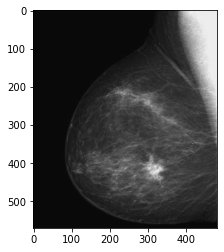

In [4]:
plt.imshow(breast, cmap='gray');

In [5]:
breast.dtype

dtype('uint8')

#### 1(a). Grafique el inverso de la imagen `breast`

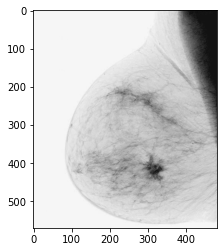

In [6]:
plt.imshow(breast.max()-breast, cmap='gray');

#### 1(b). Cree una función para realizar un ajuste de contraste de tal forma que mapee los valores de intensidad  de la imagen de entrada a nuevos valores de intensidad en la imagen de salida.  La función debe usarse de la siguiente forma `im_out=image_adjust(im_in, range_in= (low_in, high_in), range_out=(low_out, high_out), gamma)`. La función mapea los valores entre low_in y high_in a valores entre low_out y hight out, de tal forma que los valores por debajo de low_in y por encima de high_out son cortados.  La función debe aceptar cualquier tipo de imagen (en escala de grises), y el resto de parámetros (que no es la imagen), debe estar entre 0 y 1 (siendo cero el valor mínimo de intensidad y 1 correspondiente al valor máximo del formato, por ejemplo en uint8, 1 corresponde a 255).  El parámetro gamma especifica la forma de la curva que mapea la intensidad de los valores de la imagen de entrada a la de salida. La siguiente figura aclara como debe ser la forma que produce dicha función:
![](images/ajustarimagen.png)

Sugerencia: Para convertir un rango de imágenes de (a,b) a (c, d) se puede utilizar la ecuación de una recta : $$y = ((d-c) / (b-a)) * (x-a) + c$$ Sin embargo, es mejor usar una ecuación más generalizada:
$$y = ((x-a) / (b-a)) ^ \gamma * (d-c) + c$$ Si $\gamma$ es igual a 1, entonces se usa la ecuación lineal.
Cuando gamma no es igual a 1, la transformación no es lineal. Es recomendable usar `skimage.util.img_as_float`.

In [7]:
def image_adjust(im_in, range_in= (0, 1), range_out=(0, 1), gamma=1):
    """Documente y complete la funcion"""
    I = skimage.util.img_as_float(im_in)
    a = range_in[0]
    b = range_in[1]
    c = range_out[0]
    d = range_out[1]
    img_out = (((I-a)/(b-a))**(gamma))*(d-c) + c
    # img_out[img_out < a] = c
    # img_out[img_out > b] = d
    return img_out

#### 1(c). 
- Pruebe la función de `image_adjust` expandiendo las intensidades mínima y máxima de la imagen `breast` al rango de (0.5,0.75).
- Pruebe también a mejorar la imagen aplicando sólo un `gamma=2`.  
- Usando `numpy.percentile` reescale las intensidades  mínima y máxima de `breast` al percentile 1 y 99 (`gamma=1`) sobre la imagen original y la imagen invertidad.
- Grafique todas las imágenes en una sóla figura (original, invertida, ajustadas...)

#### 1(d) Grafique el histograma de la imagen `breast` usando `plt.hist()` (o en `axis.hist()` al crear ejes). 

#### 1(e). Explorando el modulo `skimage.exposure`. Utilice `exposure.rescale_intensity`, `exposure.adjust_gamma`, `exposure.adjust_log`, `exposure.equalize_hist` y `exposure_equalize_adapthist` para mejorar el contraste de la imagen `breast` y grafique el resultado comparando con la imagen original. Explique que están realizando los métodos anteriores (por ejemplo grafique también los histogramas y explique que hacen los algoritmos). 

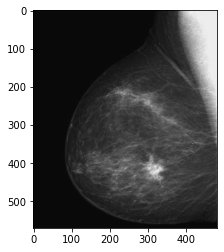

In [8]:
# C
img_out_1 = image_adjust(breast,[0.0, 1.0], [0.5,0.75],1.0)
plt.imshow(img_out_1, cmap='gray');

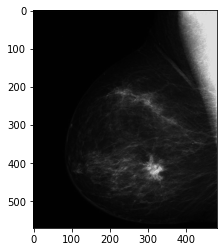

In [9]:
img_out_2 = image_adjust(breast,[0.0, 1.0], [0.5,0.75],2.0)
plt.imshow(img_out_2, cmap='gray');

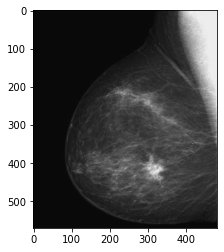

In [10]:
img_out_3 = image_adjust(breast,[breast.min(), breast.max()], [np.percentile(breast, 1),np.percentile(breast, 99)],1.0)
plt.imshow(img_out_3, cmap='gray');

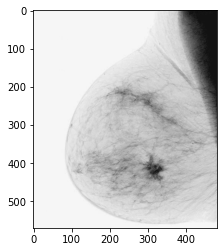

In [11]:
invertida  = breast.max()-breast
img_out_4 = image_adjust(invertida,[invertida.min(), invertida.max()], [np.percentile(invertida, 1),np.percentile(invertida, 99)],1.0)
plt.imshow(img_out_4, cmap='gray');

Text(0.5, 1.0, 'Imagen invertida, Percentiles')

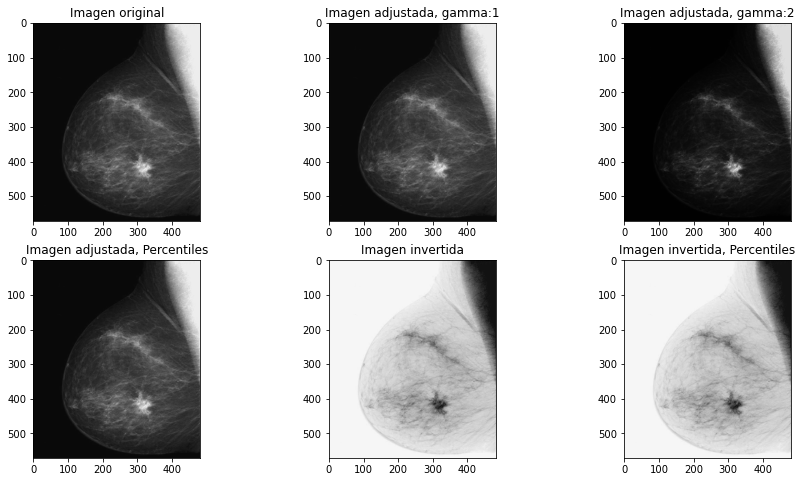

In [12]:
fig, ax = plt.subplots(2,3, figsize = (15,8))
ax[0,0].imshow(breast, cmap = 'gray')
ax[0,1].imshow(img_out_1, cmap = 'gray')
ax[0,2].imshow(img_out_2, cmap = 'gray')
ax[1,0].imshow(img_out_3, cmap = 'gray')
ax[1,1].imshow(invertida, cmap = 'gray')
ax[1,2].imshow(img_out_4, cmap = 'gray')
ax[0,0].set_title('Imagen original')
ax[0,1].set_title('Imagen adjustada, gamma:1')
ax[0,2].set_title('Imagen adjustada, gamma:2')
ax[1,0].set_title('Imagen adjustada, Percentiles')
ax[1,1].set_title('Imagen invertida')
ax[1,2].set_title('Imagen invertida, Percentiles')


#### 2(a). Realice una función de convolución 
Cree una función de convolución (sin reflejar el filtro, es decir una correlación). Recuerde que la convolución consiste en mover el filtro e ir ponderando una vecindad de pixeles (dependiendo del tamaño del filtro) y sustituyendo el pixel central por el valor ponderado:
![](images/convolution.png)

La función debe tener la forma de `convolucion_imagen(imagen, filtro, preservar)` y debe rellenar los bordes con ceros para mantener el mismo tamaño de la imagen original. Para imágenes en escala de grises es la clásica convolución en la que se pondera los valores. Sin embargo, si es una imagen con múltiples canales (o componentes) se debe particularizar los casos mediante el parámetro de `preservar`:

- Si `preservar` es `True` se debe producir una imagen con los mismos canales que la imagen de entrada. Esto significa que cada canal en la imagen debe ser separadamente filtrado por el mismo kernel de filtro.

- Si `preservar` es `False` se debe retornar una imagen de escala de grises (un canal), lo cuál es producido mediante la aplicación del filtro a cada canal, y sumando los canales resultantes.

Recuerde que el kernel debe tener sólo un canal (y debe ser verificado). 

La idea (como en el primer ejercicio) es crear una función desde "cero", haciendo uso de las facultades de skimage para representar imagenes como arrays de numpy (no mucho más alla...).

#### 2(b). Pruebe la convolución realizada
Tomese una foto, o tome una foto con el celular de algunos objetos (recuerde disminuir el tamaño a una resolución no tan alta) y pruebe la convolución con un filtro promedio de tamaño $5 \times 5$.

#### 2(c). Pruebe diferentes tipos de kernels

Defina los siguientes kernels y realice el filtrado con cada uno de ellos para generar diferentes imágenes:

Highpass                   |  Sharpen                  | Emboss
:-------------------------:|:-------------------------:|:--------------------|
![](images/highpass.png)     | ![](images/sharpen.png)     | ![](images/emboss.png)


#### 2(d). Implemente el kernel gaussiano visto en clase (S6, diapo 23)
Implemente el kernel gaussiano y apliquelo sobre la imagen que tomó antes.

#### 2(e). Implemente los filtros de sobel para estimar las componentes del gradiente. Muestre el resultado sobre la imagen tomada anteriormente (reescale la imagen entre 0 y 1 para visualizar mejor los resultados).

#### 2(f) Calcule la magnitud y fase del gradiente usando la aproximación de los filtro Sobel ([ver este link](https://en.wikipedia.org/wiki/Sobel_operator#Formulation))

Gx                 |  Gy 
:-----------------:|:------------------:
![](images/gx.png)   |  ![](images/gy.png)


#### 2(g). Intente reproducir todos los puntos anteriores usando `scipy.ndimage.convolve` y algunas de las funciones en el modulo `skimage.filters`, como `gaussian`, `sobel`, etc.

In [137]:
# 2.a Funcion de convolucion
def convolucion_imagen(imagen,filtro,preservar):
    """
    Calcula la imagen después de aplicar una convolucion
    
    args:
        imagen: imagen a la que se va a plicar filtro
        filtro: matriz cuadrada con numero impar de filas
        preservar: si es verdadero devuelve una matriz con 3 capas aplicando el proceso a cada capa.
                   Si es 0 hace la suma entre las 3 capas termino a termino y devuelve una matriz de una sola capa
                   
    returns:
        imagen despues de aplicar convolucion
    """
    # Verificacion de numero de capas de filtro
    if len(filtro.shape) > 2:
        print('El filtro tiene mas de una capa')
        return None
    if imagen.ndim == 2:
        imagen = np.expand_dims(imagen,axis=2)
    f,c = [imagen.shape[0],imagen.shape[1]]
    m = filtro.shape[0]
    cant_ceros = int(m/2)
    im_final = deepcopy(imagen)
    # Calculamos la convolucion para cada capa de la imagen
    for i in range(imagen.shape[2]):
        # ceros a los lados (I,D)
        capa = np.concatenate([np.zeros([f,cant_ceros]),imagen[:,:,i],np.zeros([f,cant_ceros])], axis = 1)
        #ceros arriba y abajo
        capa = np.concatenate([np.zeros([cant_ceros,c + (2*cant_ceros)]),
                                    capa,np.zeros([cant_ceros,c + (2*cant_ceros)])], axis = 0)
        for j in range(imagen.shape[0]-cant_ceros):
            for k in range(imagen.shape[1]-cant_ceros):
                #print("En imagen original, fila: ",j," columna: ",k)
                # indices de la matriz con bordes de 0s
                row_q,col_q = [cant_ceros + j,cant_ceros+k]
                #print("Ubicacion pixel central en matriz con 0s: ",(row_q,col_q))
                seccion = capa[(row_q - cant_ceros):(row_q + cant_ceros+1), (col_q - cant_ceros):(col_q + cant_ceros+1)]
                im_final[j,k,i] = np.sum(filtro*seccion)
    
    if preservar == True:
        return im_final
    else:
        return np.sum(im_final,axis=2)


In [138]:
# 2.b Imagen con convolucion con filtro promedio 5x5
M=5
fil = (1.0/M**2)*np.ones([5,5])
imagen = io.imread(os.path.join(DIR_IMAGES, "foto_ej4.png"))

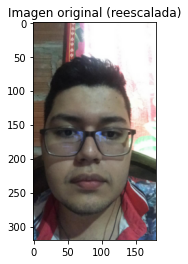

In [124]:
im_r = rescale(imagen, 0.25, anti_aliasing=True, multichannel=True)
plt.title("Imagen original (reescalada)")
plt.imshow(im_r);

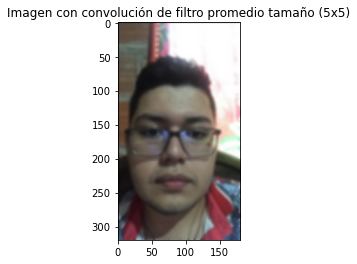

In [129]:
im_conv = convolucion_imagen(im_r,fil,True)
plt.imshow(im_conv);
plt.title("Imagen con convolución de filtro promedio tamaño (5x5)");

In [130]:
# 2.c
fil_1 = np.array([-1,0,1,-2,0,2,-1,0,1]).reshape([3,3])
print("Filtro 1:")
print(fil_1)
fil_2 = np.array([0,-1,0,-1,5,-1,0,-1,0]).reshape([3,3])
print("Filtro 2:")
print(fil_2)
fil_3 = np.array([-2,-1,0,-1,1,1,0,1,2]).reshape([3,3])
print("Filtro 3:")
print(fil_3)

Filtro 1:
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
Filtro 2:
[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]
Filtro 3:
[[-2 -1  0]
 [-1  1  1]
 [ 0  1  2]]


In [131]:
im_conv_1 = convolucion_imagen(im_r,fil_1,True)
im_conv_2 = convolucion_imagen(im_r,fil_2,True)
im_conv_3 = convolucion_imagen(im_r,fil_3,True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


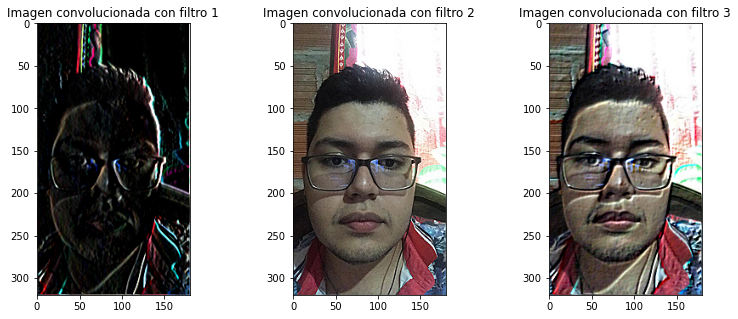

In [136]:
fig, ax = plt.subplots(1,3, figsize = (13,5))
ax[0].imshow(im_conv_1);
ax[0].set_title("Imagen convolucionada con filtro 1");
ax[1].imshow(im_conv_2);
ax[1].set_title("Imagen convolucionada con filtro 2");
ax[2].imshow(im_conv_3);
ax[2].set_title("Imagen convolucionada con filtro 3");

In [140]:
# 2.d Convolucion con filtro Gaussiano
fil_g = (1/4.8976)*np.array([0.3679,0.6065,0.3679,
                             0.6065,1.0,0.6065,
                             0.3679,0.6065,0.3679]).reshape([3,3])
im_conv_g = convolucion_imagen(im_r,fil_g,True)

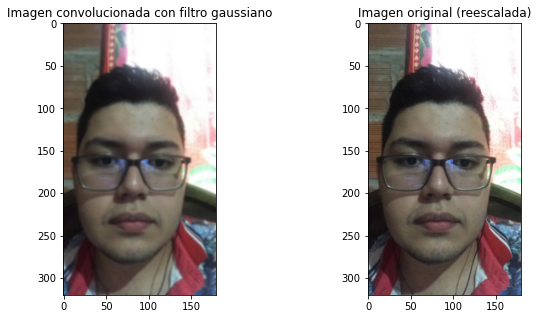

In [142]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(im_conv_g);
ax[0].set_title("Imagen convolucionada con filtro gaussiano");
ax[1].imshow(im_r);
ax[1].set_title("Imagen original (reescalada)");

#### 3. Una pequeña vista a la transformada de Fourier

##### 3(a) Realice la FFT de la imagen en escala de grises que se tomo anteriormente. Para esto use `scipy.fftpack.fft2` seguido de `scipy.fftpack.fftshift` (debe desplazar la FFT, ¿por qué?). Recuerde graficar el espectro (use `np.abs`). 

##### 3(b) Ahora multiplique la imagen (en escala de grises) por una ventana tipo "Hann", usando `skimage.filters.window` con un tamaño igual al de la imagen. Grafique la FFT del resultado (al multiplicar) siguiendo el mismo procedimiento de 3(a).  ¿Cómo difieren los espectros? ¿Cómo explica esta diferencia?

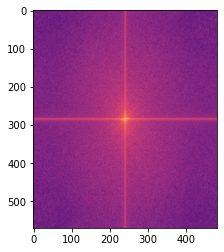

In [6]:
#a 
yf = fft2(breast)
aux = scipy.fft.fftshift(yf)
plt.imshow(np.log(np.abs(aux)), cmap= 'magma')

La Transformada de Fourier se utiliza si queremos acceder a las características geométricas de una imagen de dominio espacial. Debido a que la imagen en el dominio de Fourier se descompone en sus componentes sinusoidales, es fácil examinar o procesar ciertas frecuencias de la imagen, lo que influye en la estructura geométrica en el dominio espacial.

En la mayoría de las implementaciones, la imagen de Fourier se desplaza de tal manera que el valor DC (es decir, la media de la imagen) $F(0,0)$ se muestra en el centro de la imagen. Cuanto más lejos del centro esté un punto de imagen, mayor será su frecuencia correspondiente.

Text(0.5, 1.0, 'Transformada Final')

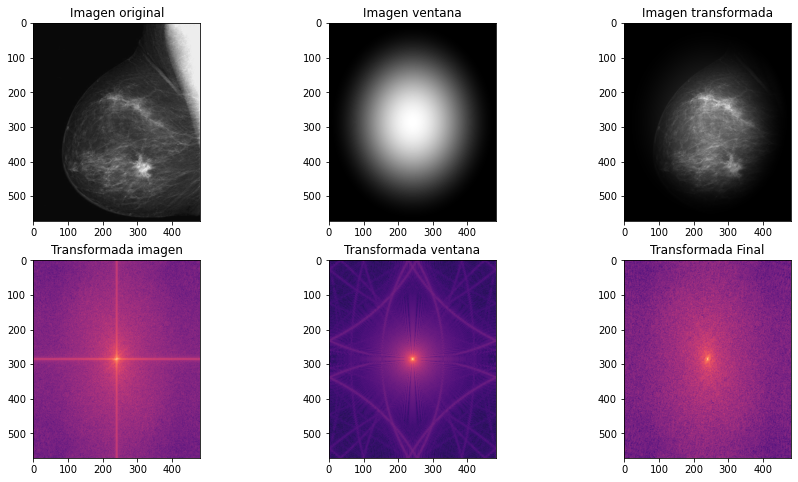

In [7]:
image = img_as_float(rgb2gray(breast))
wimage = image * window('hann', image.shape)
window_f = np.abs(fftshift(fft2(window('hann', image.shape))))
wimage_f = np.abs(fftshift(fft2(wimage)))

fig, ax = plt.subplots(2,3, figsize = (15,8))
ax[0,0].imshow(breast, cmap = 'gray')
ax[0,1].imshow(window('hann', image.shape), cmap = 'gray')
ax[0,2].imshow(wimage, cmap = 'gray')
ax[1,0].imshow(np.log(np.abs(aux)), cmap = 'magma')
ax[1,1].imshow(np.log(window_f), cmap = 'magma')
ax[1,2].imshow(np.log(wimage_f), cmap = 'magma')
ax[0,0].set_title('Imagen original')
ax[0,1].set_title('Imagen ventana')
ax[0,2].set_title('Imagen transformada')
ax[1,0].set_title('Transformada imagen')
ax[1,1].set_title('Transformada ventana')
ax[1,2].set_title('Transformada Final')

Como podemos en las imagenes de la transformada de la imagen original, estamos obteniendo unos limites en donde se van hacia el infinito y por ende apareciera un plano cartesiano, sin embargo cuando aplicamos la ventana de Hanning, nuestra imagen de la transformada sufre un cambio en donde ya no se ve las lineas de la primera imagnen, esto se debe principalmente a la estructura de la transformada de la ventana de Hanning.